In [1]:
import pandas as pd
import numpy as np

# Read trip_length_matrix from Excel
trip_length_matrix = pd.read_excel('closedtriplenght.xls',index_col = 0).values

# Read production_attraction_matrix from Excel
production_attraction_matrix = pd.read_excel('closedtripgeneration.xls',index_col = 0).values

trip_length_intervals = [(0,10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70)]

# Initialize the trip length distribution dictionary
trip_length_distribution = {interval: 0 for interval in trip_length_intervals}

# Iterate over the production attraction matrix and aggregate values based on trip length intervals
for i in range(len(trip_length_matrix)):
    for j in range(len(trip_length_matrix[i])):
        trip_length = trip_length_matrix[i][j]
        attraction = production_attraction_matrix[i][j]

        for interval in trip_length_intervals:
            if interval[0] <= trip_length <= interval[1]:
                trip_length_distribution[interval] += attraction
                break

# Print the trip length distribution
print("Trip Length Distribution:")
for interval, value in trip_length_distribution.items():
    print(f"{interval[0]}-{interval[1]}: {value}")


Trip Length Distribution:
0-10: 32642.6665118435
11-20: 38647.838912703184
21-30: 46300.767346508175
31-40: 10830.895815900345
41-50: 6324.628930377879
51-60: 19054.493638055665
61-70: 8299.70884461127


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize the initial beta value
beta = -0.1

# Perform n iterations
for iteration in range(10):
    print(f"Iteration {iteration+1}")
    
    # Calculate the f(cij) values matrix
    f_values_matrix = np.exp(beta * np.array(trip_length_matrix))
    
    # Calculate the sum of each column in the production_attraction_matrix
    column_sums = np.sum(production_attraction_matrix, axis=0)
    
    # Multiply the column sums with the corresponding column in the f_values_matrix
    d_times_f_matrix = np.multiply(f_values_matrix, column_sums)
    
    # Calculate the row totals by summing each row in the d_times_f_matrix
    row_totals = np.sum(d_times_f_matrix, axis=1)
    
    # Add row totals as the last column in the d_times_f_matrix
    d_times_f_matrix_with_totals = np.column_stack((d_times_f_matrix, row_totals))
    
    # Calculate the probability matrix
    row_sums = np.sum(d_times_f_matrix_with_totals[:, :-1], axis=1)
    probability_matrix = d_times_f_matrix_with_totals[:, :-1] / row_sums[:, np.newaxis]
    
    # Calculate the result matrix
    row_totals = np.sum(production_attraction_matrix, axis=1)
    result_matrix = probability_matrix * row_totals[:, np.newaxis]
    
    # Calculate the total number of trips for each interval
    interval_trips = {interval: 0 for interval in trip_length_intervals}
    for row in range(len(trip_length_matrix)):
        for col in range(len(trip_length_matrix[row])):
            trip_length = trip_length_matrix[row][col]
            for interval in trip_length_intervals:
                lower_bound, upper_bound = interval
                if lower_bound <= trip_length <= upper_bound:
                    interval_trips[interval] += result_matrix[row][col]
    
    # Update the trip length distribution
    updated_trip_length_distribution = {
        interval: trip_length_distribution[interval] / interval_trips[interval]
        for interval in trip_length_distribution
    }
    
    # Get the number of rows and columns in the matrix
    num_rows = len(trip_length_matrix)
    num_cols = len(trip_length_matrix[1])
    
    # Create arrays for regression
    trip_lengths = []
    ln_values = []
    
    # Generate the regression input and target arrays
    for col in range(num_cols):
        for row in range(num_rows):
            trip_length = trip_length_matrix[row][col]
            fcij_value = np.exp(beta * trip_length)
            updated_trip_length_dist = None
            for interval, value in updated_trip_length_distribution.items():
                lower_bound, upper_bound = interval
                if lower_bound <= trip_length <= upper_bound:
                    updated_trip_length_dist = value
                    break
            updated_fcij_value = fcij_value * updated_trip_length_dist if updated_trip_length_dist is not None else 0.0
            ln_updated_fcij_value = np.log(updated_fcij_value)
            
            # Append trip_length and ln_updated_fcij_value to the respective lists
            trip_lengths.append(trip_length)
            ln_values.append(ln_updated_fcij_value)
    
    # Convert the lists to NumPy arrays
    trip_lengths_array = np.array(trip_lengths)
    ln_values_array = np.array(ln_values)
    
    # Reshape the input array to a 2D array if needed
    trip_lengths_array = trip_lengths_array.reshape(-1, 1)
    
    # Create a linear regression model without an intercept
    model = LinearRegression(fit_intercept=False)
    
    # Fit the model to the data
    model.fit(trip_lengths_array, ln_values_array)
    
    # Get the coefficient (slope) of the regression line
    slope = model.coef_[0]
    
    # Update the beta value with the regression coefficient
    beta = slope
    
    # Print the regression line equation and beta value for the iteration
    print(f"Regression Line: Y = {slope:.10f} * X")
    print(f"Beta for Iteration {iteration+1}: {beta:.10f}")
    print()

# Convert interval_trips to an array
interval_trips_array = np.array(list(interval_trips.values()))
 # Convert the result matrix values to integers
result_matrix = result_matrix.astype(int)
# Print the array of interval trips for the last iteration
print("Final Trip Lenght Distribution:", interval_trips_array)
print("Final Matrix:", result_matrix)



   

Iteration 1
Regression Line: Y = -0.0655662125 * X
Beta for Iteration 1: -0.0655662125

Iteration 2
Regression Line: Y = -0.0520817719 * X
Beta for Iteration 2: -0.0520817719

Iteration 3
Regression Line: Y = -0.0458808261 * X
Beta for Iteration 3: -0.0458808261

Iteration 4
Regression Line: Y = -0.0427803898 * X
Beta for Iteration 4: -0.0427803898

Iteration 5
Regression Line: Y = -0.0411615780 * X
Beta for Iteration 5: -0.0411615780

Iteration 6
Regression Line: Y = -0.0402968519 * X
Beta for Iteration 6: -0.0402968519

Iteration 7
Regression Line: Y = -0.0398292607 * X
Beta for Iteration 7: -0.0398292607

Iteration 8
Regression Line: Y = -0.0395747390 * X
Beta for Iteration 8: -0.0395747390

Iteration 9
Regression Line: Y = -0.0394356969 * X
Beta for Iteration 9: -0.0394356969

Iteration 10
Regression Line: Y = -0.0393595905 * X
Beta for Iteration 10: -0.0393595905

Final Trip Lenght Distribution: [33798.5685766  38882.97902024 44480.59820749 10979.81706806
  5920.72970659 20113.144

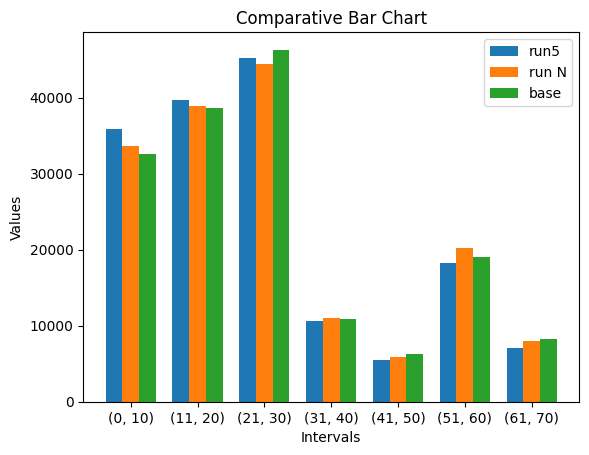

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the intervals
intervals = [(0,10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70)]

# Define the "run N" values and "base" values
base_values = [32642.6665118435, 38647.838912703184, 46300.767346508175, 10830.895815900345, 6324.628930377879, 19054.493638055665, 
        8299.70884461127 ]
run5 = [35899.78595748, 39672.65724347, 45149.705007,   10642.56360237, 5507.70604429, 18226.08333592,  7002.49880947]
run_n_values = [333798.5685766,  38882.97902024, 44480.59820749 10979.81706806
  5920.72970659 20113.1444431,   7925.16297793]


# Set the width of each bar
bar_width = 0.25

# Set the x locations of the bars
index = np.arange(len(intervals))




# Create the bar chart for "run1" values
plt.bar(index, run5, bar_width, label='run5')

# Create the bar chart for "run N" values
plt.bar(index + bar_width, run_n_values, bar_width, label='run N')


# Create the bar chart for "base" values
plt.bar(index + 2*bar_width, base_values, bar_width, label='base')

# Set the x-axis ticks and labels
plt.xticks(index + bar_width, intervals)

# Set the title and labels for the chart
plt.title('Comparative Bar Chart')
plt.xlabel('Intervals')
plt.ylabel('Values')

# Add a legend
plt.legend()

# Display the chart
plt.show()
